In [1]:
! pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Local RAG agent with LLaMA3

We'll combine ideas from paper RAG papers into a RAG agent:

- **Routing:**  Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- **Fallback:** Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884.pdf)). Fallback to web search if docs are not relevant to query
- **Self-correction:** Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question

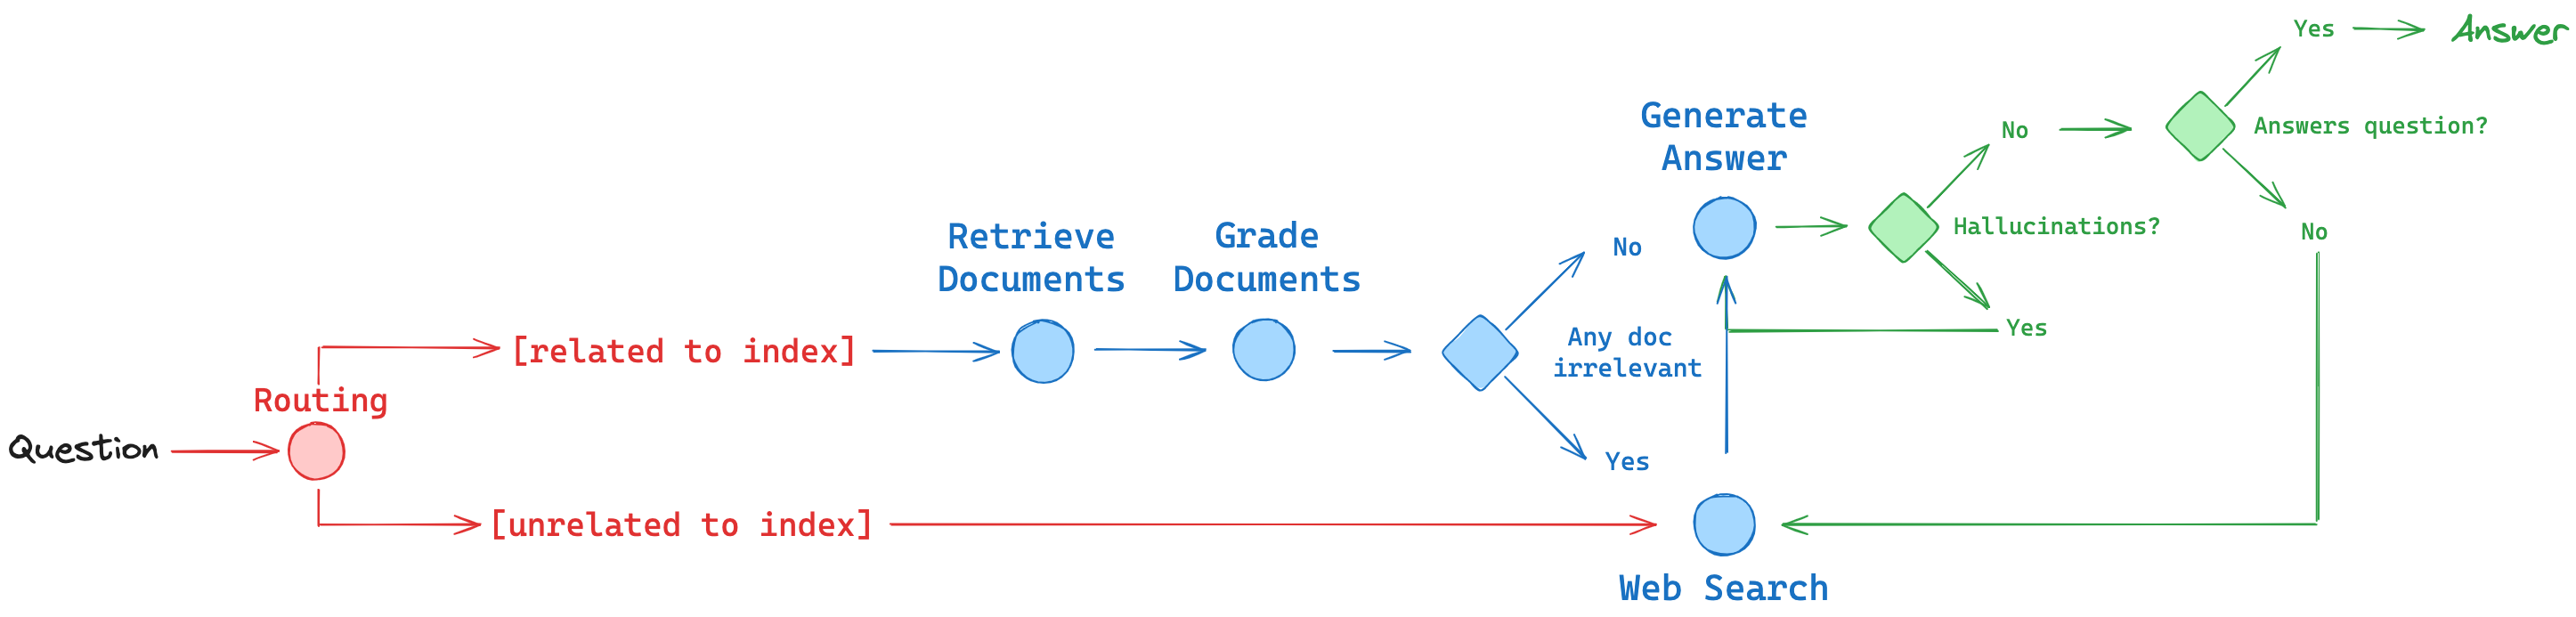

## Local models

#### Embedding

[Sentence Transformers models -- SBERT models](https://sbert.net/docs/pretrained_models.html)

```
pip install sentence-transformers
```

[GPT4All Embeddings](https://blog.nomic.ai/posts/nomic-embed-text-v1):

```
pip install langchain-nomic
```

### LLM

Use [Ollama](https://ollama.ai/) and [llama3](https://ollama.ai/library/llama3):

```
ollama pull llama3
```

Prompting documentation for LLAMA3:

https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/




In [151]:
### Tracing 
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'ls__fe633ef5a71843baa5d07db00d83cd68'
os.environ['PINECONE_API_KEY'] = "db004a52-8d38-49e6-8731-0f0a562d10b1"


In [152]:
### LLM
local_llm = 'llama3'

In [153]:
import sys
print(sys.executable)

c:\Users\Koke\Desktop\MASTER_IA\TFM\proyectoCHROMADB\tfmenv\Scripts\python.exe


### Sentence transformers --- LLM  sentence embeddings tipo siamese BERT (SBERT)
- modelo multilingual de hugginface (modelo de microsoft tipo SBERT): paraphrase-multilingual-MiniLM-L12-v2 
- modelo de lib GPT4AllEmbeddings (modelo tipo SBERT pero para ingles y mas pequeño) : all‑MiniLM‑L6‑v2.gguf2.f16.gguf	

In [ ]:
from langchain_community.embeddings import GPT4AllEmbeddings 
from langchain.embeddings import HuggingFaceEmbeddings 
EMBEDDING_MODEL = HuggingFaceEmbeddings(
                model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
                                    )
EMBEDDING_MODEL_GPT4 = GPT4AllEmbeddings(model_name ="all‑MiniLM‑L6‑v2.gguf2.f16.gguf")


### ChromaDB, PineconeDB  and retrievers

In [260]:
# Embedding of chunks and adding them to vectorDB
from langchain_community.vectorstores import Chroma
from langchain_pinecone import PineconeVectorStore
import chromadb

#Conexion to ChromaDB running in container locally
chroma_client = chromadb.HttpClient(host='localhost', port=8000)
INDEX_NAME = "llama3"

# Delete index if already exists
try : 
    chroma_client.delete_collection(name=INDEX_NAME)
except:
    print(f"No collection with name {INDEX_NAME}")

# Initialize a collection inside the vectorDB from documents chunks
chroma_vectorstore = Chroma(
                            embedding_function = EMBEDDING_MODEL,   
                            client = chroma_client,
                            collection_name=INDEX_NAME,
                            collection_metadata = {"hnsw:space": "cosine"} # dict o [deafult] None donde le puedes pasar metadata igual que se hace en el metodo 
                                                        # : chroma_client.create_collection en su argumento (que tambien es un dict)
                                                        # : "metadata" --- ejemplo metadata={"hnsw:space": "l2"} l2 is default
                                    )

pinecone_vectorstore = PineconeVectorStore.from_existing_index(
                                                            index_name = "llama3", 
                                                            embedding = EMBEDDING_MODEL
                                                        )

print(chroma_client.get_collection(name=INDEX_NAME))

# Retriever
retriever_chroma = chroma_vectorstore.as_retriever(search_kwargs = {"k" : 3})
retriever_pinecone = pinecone_vectorstore.as_retriever(search_kwargs = {"k" : 3})


name='llama3' id=UUID('bee32edd-02a7-4984-8cb3-2ae2a292ec89') metadata={'hnsw:space': 'cosine'} tenant=None database=None


### Documents, pdf,html ... extractions for future splitting, embedding and storing in ChromaDB

#### boe pdf extraction, chunking, embedding and storage

In [263]:

import os
import requests
from datetime import datetime, timedelta
import xml.etree.ElementTree as ET
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter


# URL base y configuración de directorios
boe_url = 'https://boe.es'
destino_local_raiz = './documentos'  # Ruta relativa para mayor compatibilidad
destino_local = os.path.join(destino_local_raiz, 'boe', 'dias')
print(destino_local)
boe_api_sumario = f'{boe_url}/diario_boe/xml.php?id=BOE-S-'

# Fechas de inicio y fin para la descarga de documentos
desde = '20240415'
hasta = '20240415'

fecha = datetime.strptime(desde, '%Y%m%d')
fecha_fin = datetime.strptime(hasta, '%Y%m%d')

def traer_xml(url, destino):
    
    print("destino",destino)
    # Asegurarse de que 'destino' incluya un nombre de archivo.
    if not os.path.exists(os.path.dirname(destino)):
        os.makedirs(os.path.dirname(destino), exist_ok=True)
    
    response = requests.get(url)
    if response.status_code == 200:
        with open(destino, 'wb') as file:
            file.write(response.content)
    else:
        print(f'Error al descargar el documento: {response.status_code} URL: {url}')

def extraer_urls_pdf(archivo_xml):
    tree = ET.parse(archivo_xml)
    root = tree.getroot()

    # Extraemos todas las URLs de los PDFs
    #####
    ## Podria añadir extraccion de metadatos del archivo xml para cada dia (un xml por dia y varios pdfs)
    ## despues asociar esos metadatos a cada embedding de cada pdf de cada dia en el proceso de vewctorDB
    #####
    urls_pdf = []
    for urlPdf in root.findall('.//urlPdf'):
        url = urlPdf.text  # Obtén el texto del elemento, que es la URL
        urls_pdf.append(url)
    return urls_pdf

def descargar_pdf(url_base, url_pdf, ruta_destino):
    url_completa = url_base + url_pdf
    respuesta = requests.get(url_completa)
    if respuesta.status_code == 200:
        nombre_pdf = url_pdf.split('/')[-1]  # Extraemos el nombre del archivo desde la URL
        ruta_completa_pdf = os.path.join(ruta_destino, nombre_pdf)
        
        # Asegúrate de que el directorio de destino existe
        os.makedirs(os.path.dirname(ruta_completa_pdf), exist_ok=True)
        
        with open(ruta_completa_pdf, 'wb') as archivo:
            archivo.write(respuesta.content)
        print(f'Archivo descargado con éxito: {ruta_completa_pdf}')
        return ruta_completa_pdf
    else:
        print(f'Error al descargar {url_completa}: {respuesta.status_code}')


# Splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300, chunk_overlap=10, length_function=len
)

def doc_to_vectordb(db : list, docs):
    for db_i in db:
        db_i.add_documents(documents = docs)


while fecha <= fecha_fin:
    fecha_ymd = fecha.strftime('%Y%m%d')
    print(f'Fecha descarga BOE : {fecha}')
    carpeta_fecha = os.path.join(destino_local, fecha.strftime('%Y'), fecha.strftime('%m'), fecha.strftime('%d'))
    
    fichero_sumario_xml = os.path.join(carpeta_fecha, 'index.xml')
    print("fichero_sumario_xml : ", fichero_sumario_xml)
    
    # Eliminar el sumario XML si existe
    if os.path.exists(fichero_sumario_xml):
        os.remove(fichero_sumario_xml)
    
    print(f'Solicitando {boe_api_sumario}{fecha_ymd} --> {fichero_sumario_xml}')
    traer_xml(url = boe_api_sumario + fecha_ymd, destino = fichero_sumario_xml)
    
    urls_pdf = extraer_urls_pdf(fichero_sumario_xml)
    print(f'urls PDFs totales para la fecha {fecha} : {len(urls_pdf)}')
    for num_pdfs, url_pdf in enumerate(urls_pdf):
        if num_pdfs < 5:
            loader = PyPDFLoader(descargar_pdf(url_base = boe_url, url_pdf = url_pdf, ruta_destino = carpeta_fecha))
            doc_to_vectordb(
                            db = [pinecone_vectorstore,chroma_vectorstore],
                            docs = text_splitter.split_documents(documents = loader.load()) ) # .load() -> List[Document] // .split_documents() -> List[Document]
        else:
            print(f'No se descargarán mas PDFs para la fecha : {fecha} ')
            break
    
    fecha += timedelta(days=1)



./documentos\boe\dias
Fecha descarga BOE : 2024-04-15 00:00:00
fichero_sumario_xml :  ./documentos\boe\dias\2024\04\15\index.xml
Solicitando https://boe.es/diario_boe/xml.php?id=BOE-S-20240415 --> ./documentos\boe\dias\2024\04\15\index.xml
destino ./documentos\boe\dias\2024\04\15\index.xml
urls PDFs totales para la fecha 2024-04-15 00:00:00 : 398
Archivo descargado con éxito: ./documentos\boe\dias\2024\04\15\BOE-S-2024-92.pdf
Archivo descargado con éxito: ./documentos\boe\dias\2024\04\15\BOE-A-2024-7293.pdf
Archivo descargado con éxito: ./documentos\boe\dias\2024\04\15\BOE-A-2024-7294.pdf
Archivo descargado con éxito: ./documentos\boe\dias\2024\04\15\BOE-A-2024-7295.pdf
Archivo descargado con éxito: ./documentos\boe\dias\2024\04\15\BOE-A-2024-7296.pdf
No se descargarán mas PDFs para la fecha : 2024-04-15 00:00:00 


In [154]:
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

"""
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
"""
urls = ['https://es.wikipedia.org/wiki/Las_Rozas_de_Madrid']
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]



In [155]:
# BOE PDF
from langchain.document_loaders import PyPDFLoader
def pdf_loader(pdf):
    temp_dir = r"C:\Users\Koke\Desktop\MASTER_IA\TFM\proyectoCHROMADB\documentos"
    pdf_path = os.path.join(temp_dir, pdf)
    print(pdf_path)
    loader = PyPDFLoader(pdf_path)
    return loader.load() 
    # los document objects tienen como atributos: .page_content [alamcena elk contenido paginas de pdf en tipo str] -- .metadata [dict con keys : "source" value: (ruta del  pdf absoluta), "page" etc]
    """ 
    # Prueba para cconocer mejor atributos de objeto document    
    with open('prueba.txt', "w") as file:
        for doc in doc_object:
            file.write(doc.page_content)
    """


### Text splitter


In [156]:

"""
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
"""
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250, chunk_overlap=10, length_function=len
)

#doc_splits = text_splitter.split_documents(docs_list)
doc_splits = text_splitter.split_documents(pdf_loader("boe_2.pdf"))
print(type(doc_splits))
print((doc_splits))



C:\Users\Koke\Desktop\MASTER_IA\TFM\proyectoCHROMADB\documentos\boe_2.pdf
<class 'list'>
[Document(page_content='Artículo 63. Perfil de contratante.  \n1. Los órganos de contratación difundirán exclusivamente a través de Internet su perfil de contratante, \ncomo elemento que agrupa la información y documentos relativos a su actividad contractual al objeto', metadata={'source': 'C:\\Users\\Koke\\Desktop\\MASTER_IA\\TFM\\proyectoCHROMADB\\documentos\\boe_2.pdf', 'page': 0}), Document(page_content='de asegurar la transparencia y el acceso público a l os mismos. La forma de acceso al perfil de \ncontratante deberá hacerse constar en los pliegos y documentos equivalentes, así como en los anuncios', metadata={'source': 'C:\\Users\\Koke\\Desktop\\MASTER_IA\\TFM\\proyectoCHROMADB\\documentos\\boe_2.pdf', 'page': 0}), Document(page_content='de licitación en todos los casos. La difusión del perfil de contratante no obstará la utilización de otros \nmedi os de publicidad adicionales en los casos 

### Sentence transformers --- LLM  sentence embeddings tipo siamese BERT (SBERT)
- modelo multilingual de hugginface (modelo de microsoft tipo SBERT): paraphrase-multilingual-MiniLM-L12-v2 
- modelo de lib GPT4AllEmbeddings (modelo tipo SBERT pero para ingles y mas pequeño) : all‑MiniLM‑L6‑v2.gguf2.f16.gguf	

In [200]:
from langchain_community.embeddings import GPT4AllEmbeddings 
from langchain.embeddings import HuggingFaceEmbeddings 

EMBEDDING_MODEL = HuggingFaceEmbeddings(
                model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
                                    )
EMBEDDING_MODEL_GPT4 = GPT4AllEmbeddings(model_name ="all‑MiniLM‑L6‑v2.gguf2.f16.gguf")

### Chroma DB and retriever

In [238]:

# Embedding of chunks and adding them to vectorDB
from langchain_community.vectorstores import Chroma
import chromadb

chroma_client = chromadb.HttpClient(host='localhost', port=8000)
INDEX_NAME = "llama3"

# Delete index if already exists
try : 
    chroma_client.delete_collection(name=INDEX_NAME)
except:
    print(f"No collection with name {INDEX_NAME}")

# Initialize a collection inside the vectorDB from documents chunks
chroma_vectorestore = Chroma.from_documents(
                                    documents = tuple_docs,
                                    embedding = EMBEDDING_MODEL,   
                                    client = chroma_client,
                                    collection_name=INDEX_NAME,
                                    collection_metadata = {"hnsw:space": "cosine"} # dict o [deafult] None donde le puedes pasar metadata igual que se hace en el metodo 
                                                                # : chroma_client.create_collection en su argumento (que tambien es un dict)
                                                                # : "metadata" --- ejemplo metadata={"hnsw:space": "l2"} l2 is default
                                    )
retriever_chroma = chroma_vectorestore.as_retriever(search_kwargs = {"k" : 3})
print(chroma_client.get_collection(name=INDEX_NAME))

No collection with name llama3
page_content='I. DISPOSICIONES GENERALES\nMINISTERIO DE ASUNTOS EXTERIORES, UNIÓN EUROPEA Y \nCOOPERACIÓN\nOrganización\nOrden AUC/319/2024, de 9 de abril, por la que se crea la Oficina Consular honoraria' metadata={'source': './documentos\\boe\\dias\\2024\\04\\15\\BOE-S-2024-92.pdf', 'page': 0}
('page_content', 'I. DISPOSICIONES GENERALES\nMINISTERIO DE ASUNTOS EXTERIORES, UNIÓN EUROPEA Y \nCOOPERACIÓN\nOrganización\nOrden AUC/319/2024, de 9 de abril, por la que se crea la Oficina Consular honoraria')


AttributeError: 'tuple' object has no attribute 'page_content'

In [245]:
## Verify the storage inside chroma database
num = 2
for id in chroma_vectorestore.get()["ids"]:
    if num > 0:
        print(chroma_vectorestore.get(include=['embeddings', 'documents', 'metadatas']))
        num -= 1

{'ids': ['118171a3-3be7-42b9-a24a-3418c46dabec', '14144d75-7382-4e4d-b31a-11bd4b7f071d', '26b34711-ce63-4673-a4fb-bfa0a7d9712f', '2c977609-d046-4af6-899c-7e61c8b6fa86', '330917fb-9701-4964-b683-2f01c7610fef', '5fe0ddb3-6783-4b74-beb6-6c68b1261c6d', '7aec9ec4-6c8f-4797-8f56-067d5986b3d2', '94a04869-3f6a-47d3-b0b8-e963473f0b24', '983fa637-786e-495a-8623-883d1ffee0fa', '9b056fcb-d4a2-4813-a09a-4dd003fff3e7', 'c951cfda-2d08-483c-965f-78d4ad1d777e', 'e58e7f3a-f73e-4b89-b58b-631d9b789c6e', 'f19513e8-2123-4a18-8fdc-a8ec235c4fbb'], 'embeddings': [[-0.1429286003112793, 0.36161163449287415, -0.02122342772781849, 0.016048187389969826, 0.0004729979846160859, -0.0022109909914433956, -0.22385993599891663, 0.25673168897628784, -0.0737786665558815, 0.08876933157444, -0.04281022027134895, -0.12235461920499802, -0.1587759107351303, 0.15952520072460175, -0.15165121853351593, -0.0536927655339241, -0.10411805659532547, -0.06941039860248566, 0.3173951506614685, 0.18805953860282898, 0.2375941425561905, 0.219

In [264]:
# Prueba sobre pinecone db usando el retriever
query = "La duración total de las enseñanzas en ciclos de grado medio"
response = retriever_chroma.invoke(query)
print("Number of embeddings retrieved : ", len(response))
print("Best cosine similarity : ", response[0].page_content)



Number of embeddings retrieved :  3
Best cosine similarity :  Técnico Deportivo en Atletismo es de 1.005 horas. Estas enseñanzas se organizan en 
dos ciclos.
a) Ciclo inicial de grado medio en atletismo, con una duración de 430 horas.
b) Ciclo final de grado medio en atletismo, con una duración de 575 horas.


In [161]:
# nota : Instanciar clase Chroma crea un objeto equivalnete a chroma_client de la libreria chromadb pero usando libreria langchain  
print(type(doc_splits[0]))
print("Collection info : ", chroma_vectorestore.get().keys())
print("Collection info ids len : ", (chroma_vectorestore.get()["ids"]))
print("Collection docs : ", chroma_vectorestore.get()["documents"])
print("Collection embeddings (1st comp of first embedding) : ", chroma_vectorestore.get(include = ['embeddings'])["embeddings"][0][0])
print("LEN OF COLLECTION EMBEDDINGS: ", len(chroma_vectorestore.get(include = ['embeddings'])["embeddings"][0]))


<class 'langchain_core.documents.base.Document'>
Collection info :  dict_keys(['ids', 'embeddings', 'metadatas', 'documents', 'data', 'uris'])
Collection info ids len :  ['11617e5d-7477-4693-981e-c7ad0aa313f8', '1a38925b-3e3f-425e-aec5-396fdf841c47', '2a319269-5435-44a7-a4ef-c57d793426d1', '31aa4651-a5ca-4046-920b-ad4b7b31ebdc', '32150c3f-dceb-4be8-aec1-927029732d96', '3438fe75-cfd7-4dfc-b454-faeab4d7ca83', '44ba21bd-a6cb-4c03-ad99-9e0f53ff23e9', '5ff179ce-ea0c-4fdc-978f-07c53fd670b4', '6b745d44-8f64-4947-934a-4ad0fd8e0507', '6c0c6af6-a0f2-4880-98df-01b73567790c', '72d8de88-33d3-453b-9934-efaea08034b8', '8ed621d7-998d-420d-b2f3-2ca4decc555d', 'a07ad53a-f6a8-49bb-bc16-dd5fb12dd49b', 'ae361884-c849-40bd-9641-20632fd496a3', 'c1305cba-fa14-499d-963c-1f8f62cdf630', 'd6004f9f-5105-4eac-9d73-95a5bc15ad0b']
Collection docs :  ['servicios, la justificación del procedimiento utilizado para su adjudicación cuando se utilice un \nprocedimiento distinto del abierto o del restringid o, el pliego de 

### Pinecone DB and retriever

In [162]:
from langchain_pinecone import PineconeVectorStore
pinecone_vectorestore = PineconeVectorStore.from_existing_index(
                                                                index_name = "llama3", 
                                                                embedding = EMBEDDING_MODEL
                                                            )
pinecone_vectorestore.add_documents(doc_splits)
retriever_pinecone = pinecone_vectorestore.as_retriever(search_kwargs = {"k" : 3})

In [265]:
# Prueba sobre pinecone db usando el retriever
query = "La duración total de las enseñanzas en ciclos de grado medio"
response = retriever_pinecone.invoke(query)
print("Number of embeddings retrieved : ", len(response))
print("Best cosine similarity : ", response[0].page_content)

Number of embeddings retrieved :  3
Best cosine similarity :  a) Ciclo inicial de grado medio en atletismo, con una duración de 430 horas.
b) Ciclo final de grado medio en atletismo, con una duración de 575 horas.
2. Los módulos de enseñanza deportiva de este ciclo cuando se oferte en régimen


### Grader

In [266]:
### Retrieval Grader 

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

# Create a chain for the grader
llm_grader = prompt | llm | JsonOutputParser()
question = "¿Cual es la duración total de las enseñanzas en ciclos de grado medio?"

# Retrieval towards the two db (chroma and pinecone):
docs_c = retriever_chroma.invoke(question)
docs_p= retriever_pinecone.invoke(question)

# choose one [here we should apply a loop through all retirieved embedded chunks (that are indeed Document object)]:
doc_txt = docs_c[0].page_content

print(type(docs_c[0]))
print(len(docs_c))
print(len(docs))
print(doc_txt)

<class 'langchain_core.documents.base.Document'>
3
1
Técnico Deportivo en Atletismo es de 1.005 horas. Estas enseñanzas se organizan en 
dos ciclos.
a) Ciclo inicial de grado medio en atletismo, con una duración de 430 horas.
b) Ciclo final de grado medio en atletismo, con una duración de 575 horas.


### Testing the grader

In [267]:
grade_json = llm_grader.invoke({"question": question, "document": doc_txt})
print(grade_json)

{'score': 'yes'}


### Generate

In [268]:
### Generate

from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# query
question = "¿Cual es la duración total de las enseñanzas en ciclos de grado medio?"

# Retrieved docs from the two retrieval obj (chroma db and pinecone db):
docs_c = retriever_chroma.invoke(question)
docs_p= retriever_pinecone.invoke(question)

generation = rag_chain.invoke({"context": docs_p, "question": question})
print(generation)

The total duration of the teachings in cycles of medium degree is 1,005 hours. This is divided into two cycles: a) Ciclo inicial de grado medio en atletismo, with a duration of 430 hours and b) Ciclo final de grado medio en atletismo, with a duration of 575 hours.


### Prompting: 


In the PromptTemplate you provided, the roles of "system", "user", and "assistant" represent different parts of a structured prompt that likely guides the interaction or task in a conversational AI or similar setting. Here’s a breakdown of each role within the context of this template:

System
The "system" role typically represents instructions or predefined content that sets up the context or rules for the interaction. In your template, the system is instructing the assistant on how to perform its role:

Instructions: "You are an assistant for question-answering tasks."
Context Handling: "Use the following pieces of retrieved context to answer the question."
Fallback: "If you don't know the answer, just say that you don't know."
Conciseness: "Use three sentences maximum and keep the answer concise."
These instructions are intended for the assistant, detailing how it should behave or respond within the framework of this task. This is not part of the visible interaction to the end user but is essential for guiding the assistant's behavior.

User
The "user" role here appears to mark the section of the prompt where user-generated input is expected to be inserted. In this template:

Question Placeholder: The {question} variable is where the actual user's question will be inserted into the prompt. This is a dynamic part of the prompt that changes based on the actual input from the user.
Assistant
The "assistant" role signifies where the assistant’s response should begin. This label is likely used to delineate the output section where the assistant formulates its reply based on the input question and the provided context:

Answer Placeholder: The text following "assistant" is where the assistant's response is expected to be generated based on the input question and any context provided.

In [10]:
### Hallucination Grader 

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [11]:
### Answer Grader 

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question,"generation": generation})

{'score': 'yes'}

In [15]:
### Router

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents, 
    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords 
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' 
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no premable or explaination. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

{'datasource': 'vectorstore'}


In [6]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

We'll implement these as a control flow in LangGraph.

In [16]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

from langchain.schema import Document

### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

### Graph Build

In [17]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [18]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What are the types of agent memory?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('According to the provided context, there are several types of memory '
 'mentioned:\n'
 '\n'
 '1. Sensory Memory: This is the earliest stage of memory, providing the '
 'ability to retain impressions of sensory information (visual, auditory, etc) '
 'after the original stimuli have ended.\n'
 '2. Maximum Inner Product Search (MIPS): This is a long-term memory 

Trace: 

https://smith.langchain.com/public/8d449b67-6bc4-4ecf-9153-759cd21df24f/r

In [21]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": "Who are the Bears expected to draft first in the NFL draft?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Who are the Bears expected to draft first in the NFL draft?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('The Bears are expected to draft USC star and 2022 Heisman Trophy winner '
 'Caleb Williams with the No. 1 overall pick.')


Trace: 

https://smith.langchain.com/public/c785f9c0-f519-4a38-ad5a-febb59a2139c/r